In [882]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from sklearn.metrics import f1_score, recall_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics




import warnings
warnings.filterwarnings('ignore')

1) id: уникальный идентификатор
2) gender: "Мужчина", "Женщина" или "Другой"
3) age: возраст пациента
4) hypertension: 0, если у пациента нет артериальной гипертензии, 1, если у пациента есть артериальная гипертензия
5) heart_disease: 0, если у пациента нет сердечных заболеваний, 1, если у пациента есть сердечные заболевания
6) ever_married: "Нет" или "Да"
7) work_type: "ребенок", "Государственная", "Никогда не работавшая", "Частная" или "Самозанятая"
8) Residence_type: "Сельская" или "Городская"
9) avg_glucose_level: средний уровень глюкозы в крови
10) bmi: индекс массы тела
11) smoking_status: "ранее курил", "никогда не курил", "курит" или "Неизвестно".*
12) stroke: 1, если у пациента был инсульт, или 0, если нет **(target)**

In [883]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


****
EDA
****

    Проведем первичный анализ данных

In [884]:
#Общая информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


В датасете 7 вещественных колонок и 5 категориальных. Есть пропуски в одной колонке

In [885]:
#Статистика по вещественным и категориальным колонкам
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [886]:
data.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [887]:
print('Процент людей, у которых есть гипертензия:', round(len(data[data['hypertension'] == 1]) * 100 / len(data), 3), '%')
print('Процент людей, у которых есть сердечные заболевания:', round(len(data[data['heart_disease'] == 1]) * 100 / len(data), 3), '%')
print('Процент людей, у которых был инсульт:', round(len(data[data['stroke'] == 1]) * 100 / len(data), 3), '%')



Процент людей, у которых есть гипертензия: 9.746 %
Процент людей, у которых есть сердечные заболевания: 5.401 %
Процент людей, у которых был инсульт: 4.873 %


In [888]:
#Соотношение классов в таргете
data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [889]:
data['work_type'].value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [890]:
data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

    Пройдемся по каждой колонке

1. age: Средний возраст 43 года, стандартное отклонение 22 года. Есть аномалии

2. gender: 3 уникальных значения, большинство женского пола.

3. hypertension: Гипертензия есть у 10% людей.

4. heart_disease: Сердечные заболевания есть у 5% людей.

5. ever_married: 2 уникальных значения, большинство в браке

6. work_type: 5 уникальных значений, большинство значений - Private

7. Residence_type: 2 уникальных значения, большинство живет в городе  

8. avg_glucose_level: Средний уровень глюкозы около 106 ммоль\л. В колонке есть аномалии

9. bmi: В среднем показатель индекса массы тела равен 29. В колонке есть аномалии

10. smoking_status: 4 уникальных значения, большинство не курит. Однако, почти столько же значений - неизвестно.

11. stroke: Инсульт случился у 4.9%  людей.



    Визуальный анализ данных

Начнем его с корреляционного анализа

In [891]:
num_cols = data.select_dtypes(include=['int', 'float'])
num_cols.drop('id', axis=1, inplace=True)
cat_cols = data.select_dtypes(include=object)



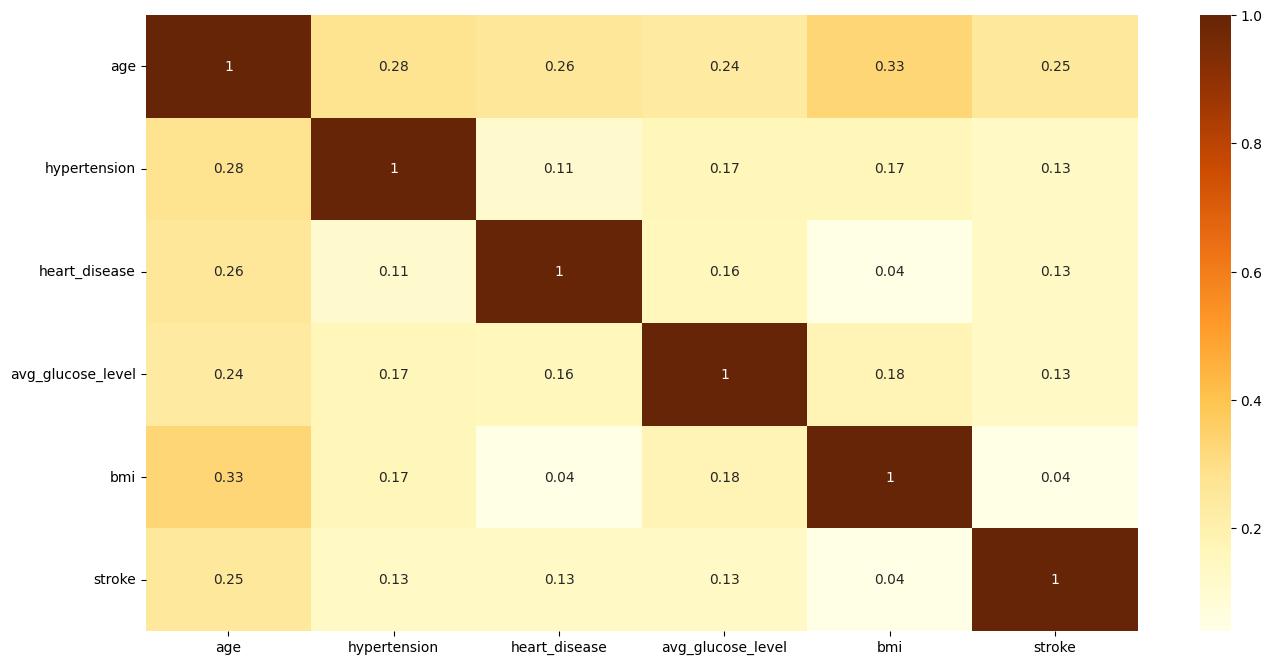

In [892]:
#Вещественные признаки будем оценивать с помощью коэффициента корреляции Пирсона

corr = num_cols.corr().round(2)
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr');

<Axes: >

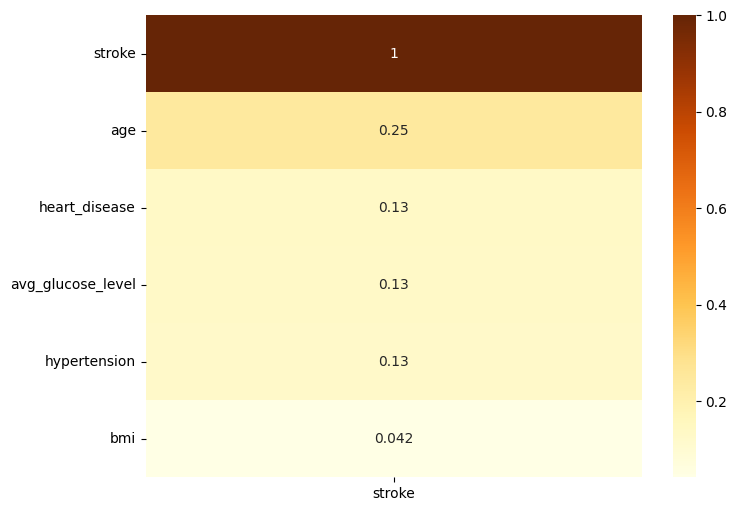

In [893]:
plt.figure(figsize=(8,6))
sns.heatmap(num_cols.corr()[['stroke']].sort_values(by='stroke',ascending=False),annot=True, cmap = 'YlOrBr')

Коэффициент корреляции Пирсона показал, что линейной зависимости в наших данных нет. Следовательно, проблема мультиколлениарности нас не коснется. Возраст - колонка, которая коррелирует хоть как-то со всеми остальными признаками

In [894]:
#Корреляцию категориальных признаков с таргетом будем оценивать с помощью коэффициента корреляции Крамера
X = data.drop('stroke', axis=1)
y = data['stroke']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for column in cat_cols:
     print(f'Корреляция {column} совместно с таргетом равна:', round(cramers_v(cat_cols[column], y), 3))



Корреляция gender совместно с таргетом равна: 0.0
Корреляция ever_married совместно с таргетом равна: 0.106
Корреляция work_type совместно с таргетом равна: 0.094
Корреляция Residence_type совместно с таргетом равна: 0.004
Корреляция smoking_status совместно с таргетом равна: 0.072


Коэффициент корреляции Крамера тоже не показал никаких зависимостей. Однако, мы еще посмотрим на эти переменные на визуальном анализе. 

Видим, что гендер никак не влияет на таргет

    Скорее всего, в данных есть более сложная зависимость

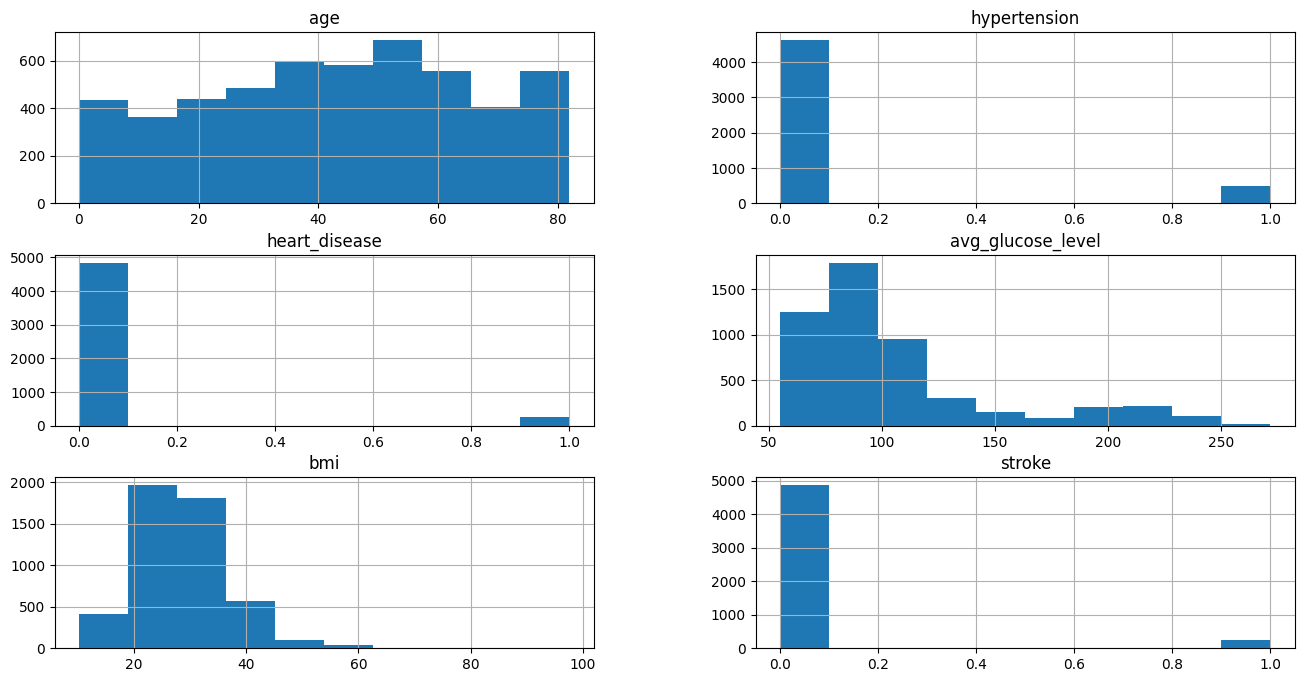

In [895]:
#Визуализируем вещественные признаки
num_cols.hist(figsize=(16, 8));

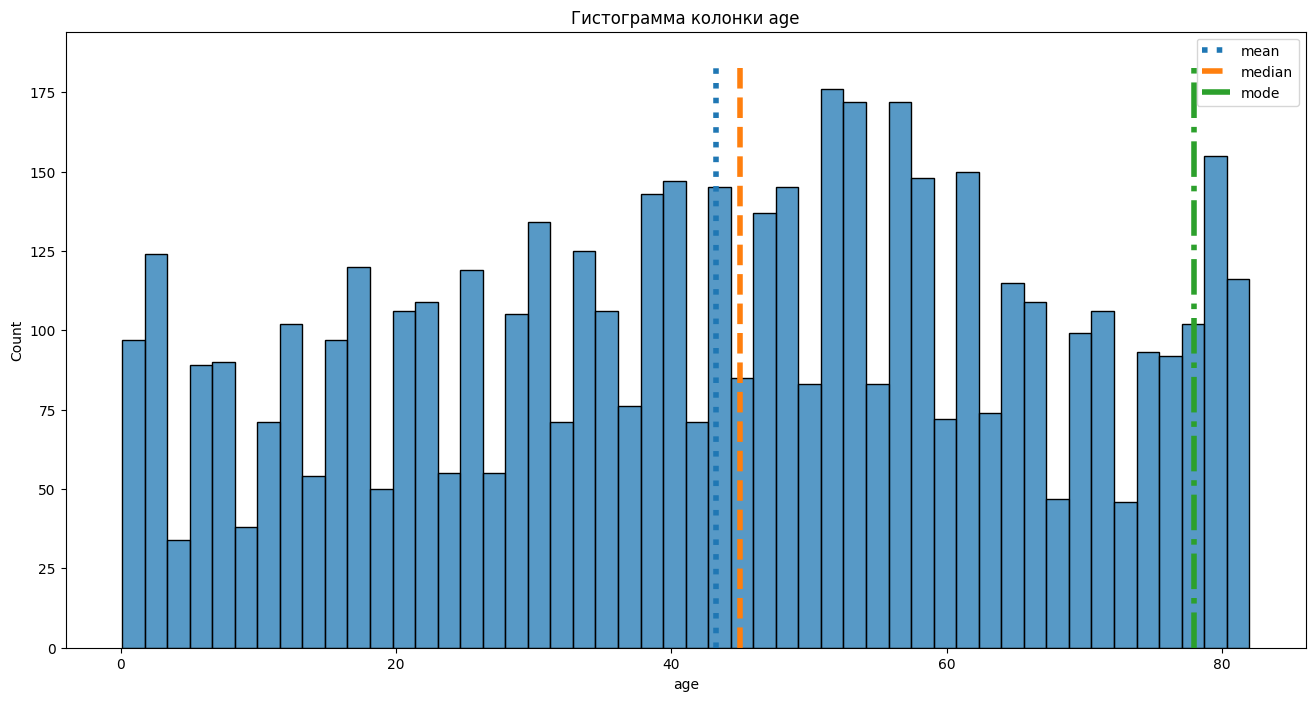

In [896]:
#Посмотрим на колонку age
target_mean = round(data['age'].mean(), 2)
target_median = data['age'].median()
target_mode = data['age'].mode()[0]

plt.figure(figsize=(16, 8))

sns.histplot(data['age'], bins=50)

y = np.linspace(0, plt.ylim()[1], 2)
plt.plot([target_mean] * 2, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 2, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 2, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Гистограмма колонки age')
plt.legend()
plt.show()


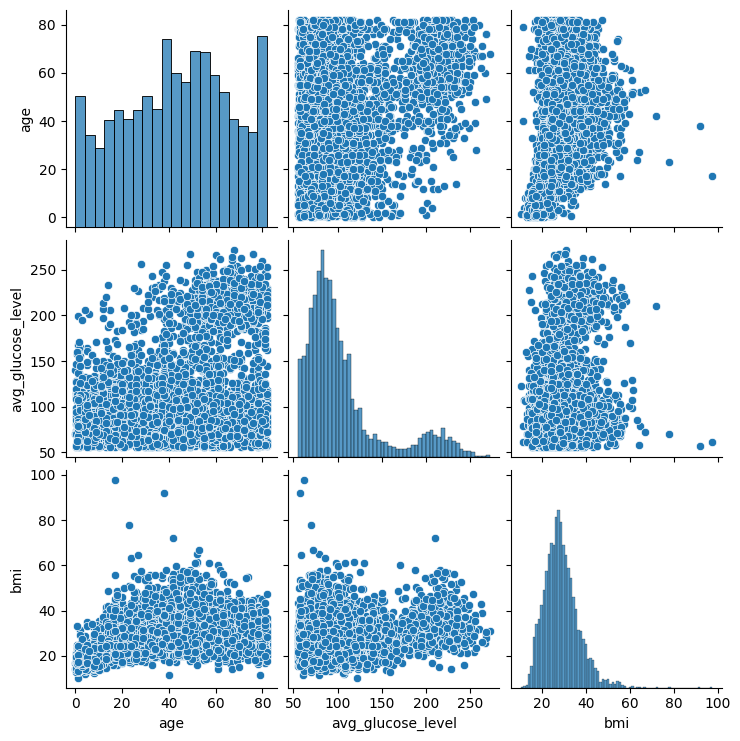

In [897]:
#Откинем бинарные признаки и посмотрим на взаимосвязи между остальными вещественными колонками
for_pairplot = data[['age', 'avg_glucose_level', 'bmi']]
sns.pairplot(for_pairplot);


График показал, что между данными действительно не видно никакой зависимости. Максимум - слабо выраженная линейная зависимость

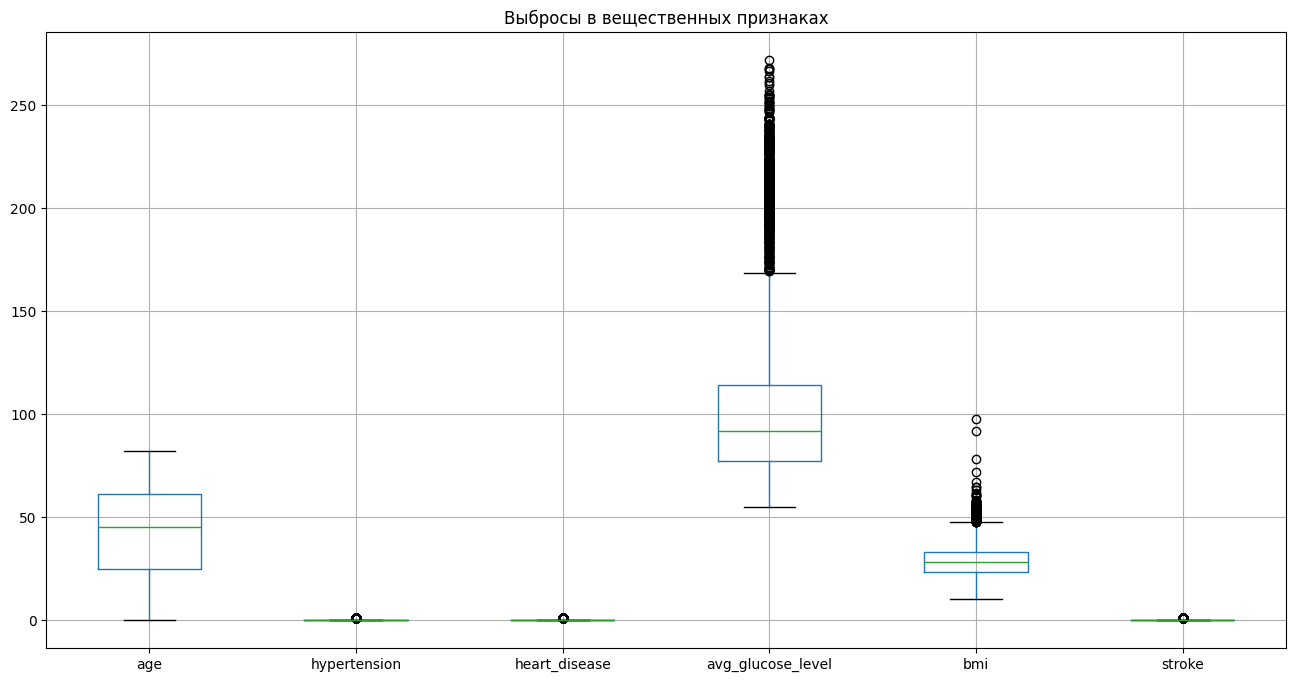

In [898]:
#Посмотрим на выбросы
num_cols.boxplot(figsize=(16, 8))
plt.title('Выбросы в вещественных признаках');

Ящики с усами показали, что аномалии присутствуют только в двух колонках. Несмотря на то, что первичный анализ указал на некие аномалии в колонке с возрастом, визуализация показала обратное

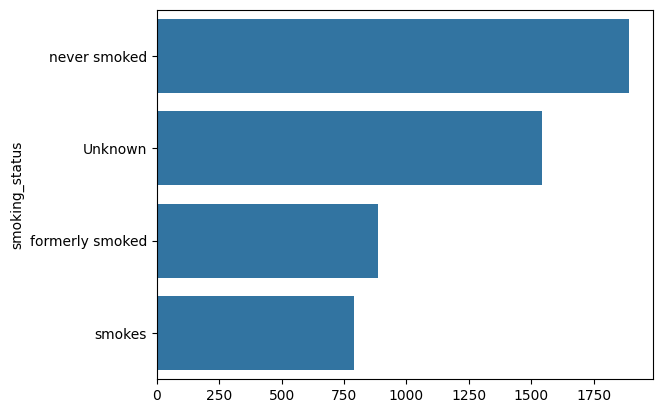

In [899]:
smoke = cat_cols['smoking_status'].value_counts()
sns.barplot(x=smoke.values, y=smoke.index);

Видим большое кол-во неизвестных данных

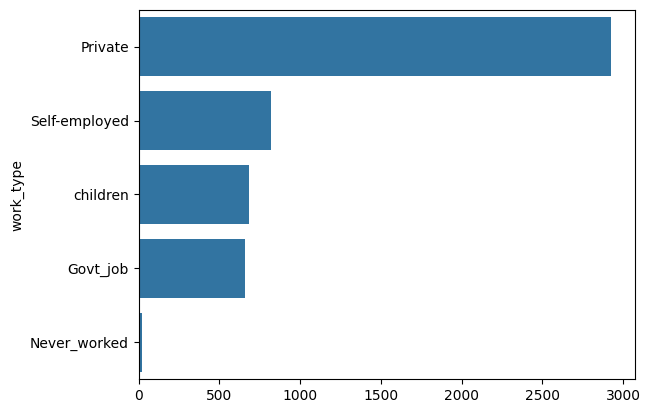

In [900]:
work = cat_cols['work_type'].value_counts()
sns.barplot(x=work.values, y=work.index);

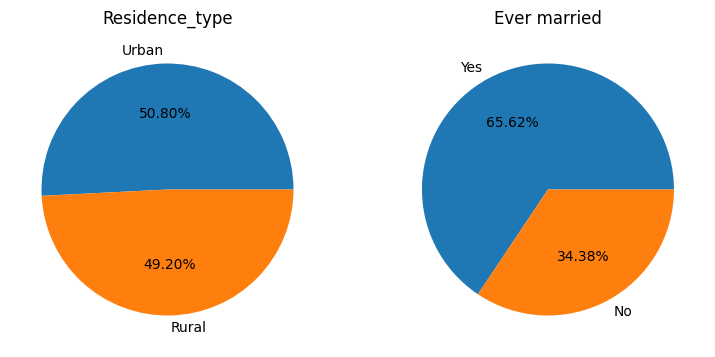

In [901]:

residence = cat_cols['Residence_type'].value_counts()
plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.title('Residence_type')
plt.pie(residence.values, labels=residence.index, autopct='%.2f%%')

married = cat_cols['ever_married'].value_counts()

plt.subplot(2, 2, 2)
plt.title('Ever married')
plt.pie(married.values, labels=married.index, autopct='%.2f%%')
plt.show()

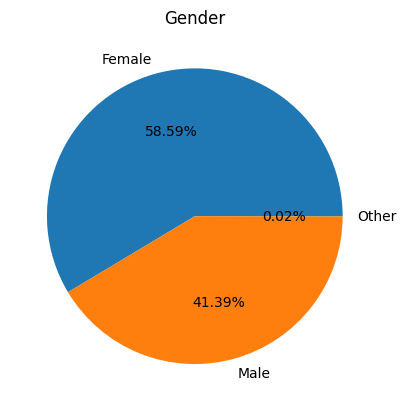

In [902]:
gender = cat_cols['gender'].value_counts()

plt.title('Gender')
plt.pie(gender.values, labels=gender.index, autopct='%.2f%%')
plt.show()

    Теперь посмотрим на взаимосвязь признаков и таргета

In [903]:
# Создадим новую колонку 'age_group' с распределением по возрастным группам
data['age_group'] = pd.cut(data['age'], bins=[0, 25, 50, 75, 100], labels=['0-25', '26-50', '51-75', '76-100'])
data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,51-75
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,51-75
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,76-100
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,26-50
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,76-100


In [904]:
data['age_group'].value_counts()

age_group
26-50     1690
51-75     1662
0-25      1293
76-100     465
Name: count, dtype: int64

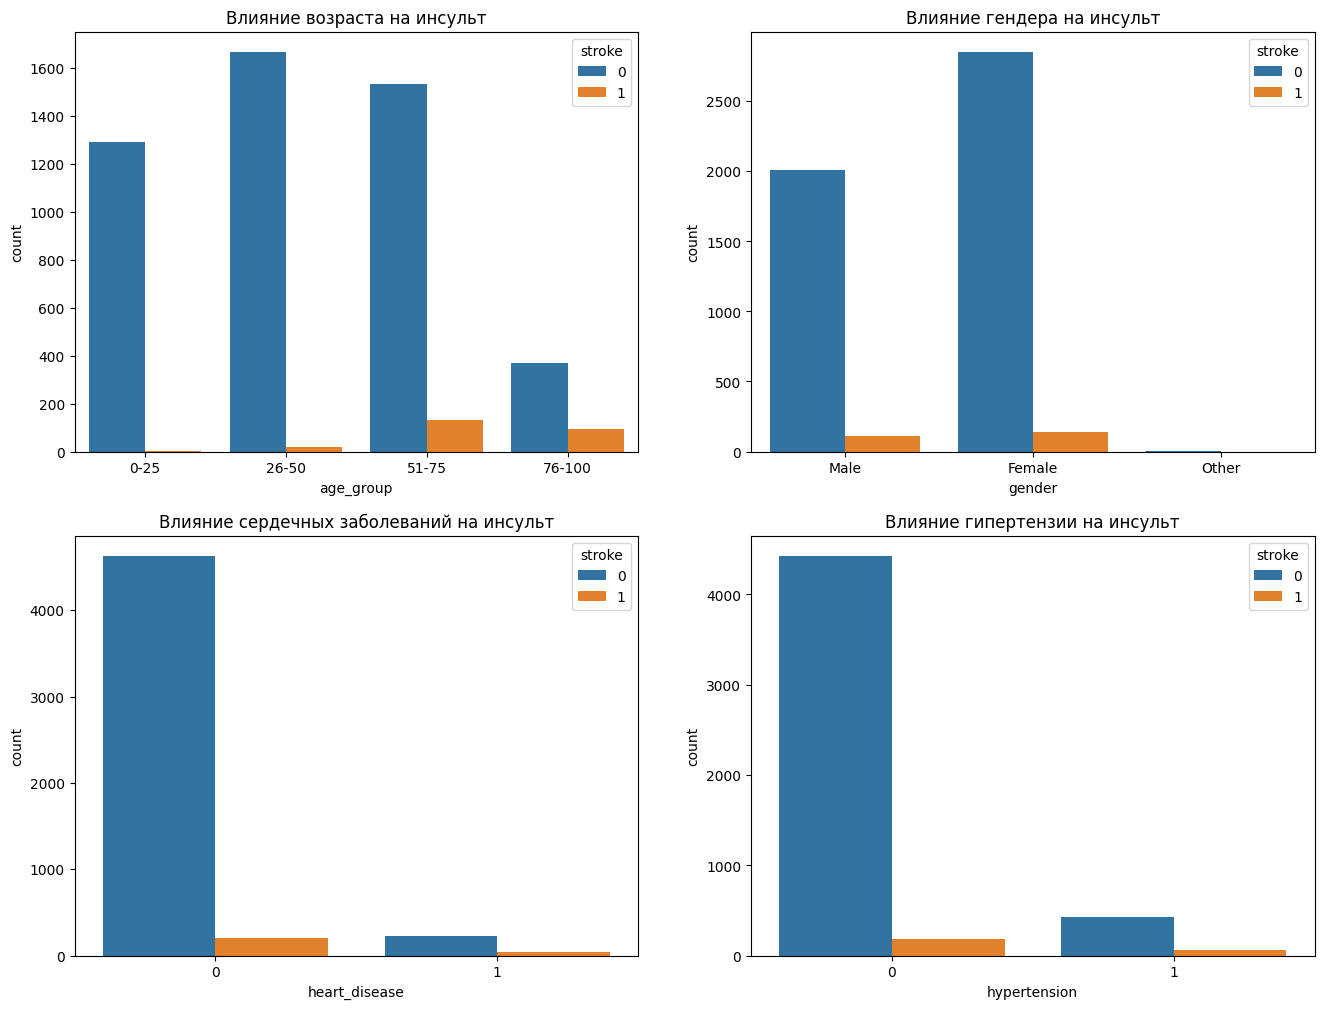

In [905]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1)
sns.countplot(x=data['age_group'],  hue = data['stroke'])
plt.title('Влияние возраста на инсульт')

plt.subplot(2, 2, 2)
sns.countplot(x=data['gender'],  hue = data['stroke'])
plt.title('Влияние гендера на инсульт')

plt.subplot(2, 2, 3)
sns.countplot(x=data['heart_disease'],  hue = data['stroke'])
plt.title('Влияние сердечных заболеваний на инсульт')

plt.subplot(2, 2, 4)
sns.countplot(x=data['hypertension'],  hue = data['stroke'])
plt.title('Влияние гипертензии на инсульт')


plt.show()

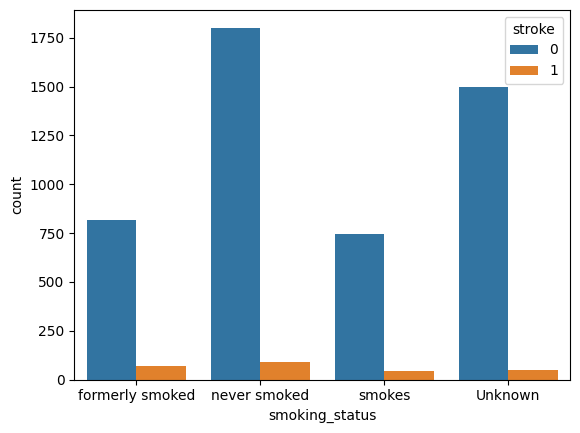

In [906]:
sns.countplot(x = data['smoking_status'], hue=data['stroke'])
plt.show()

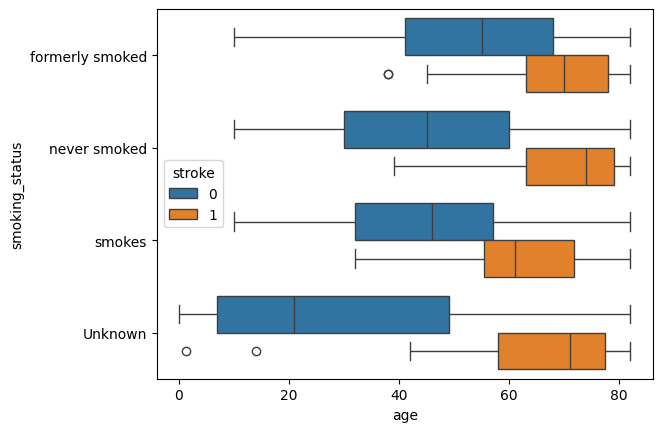

In [907]:
sns.boxplot(x = data['age'], y = data['smoking_status'], hue=data['stroke'])
plt.show()

In [908]:
data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [909]:
total_people1 = data[(data['heart_disease'] == 1) & (data['hypertension'] == 1) & (data['stroke'] == 1)].shape[0]
total_people0 = data[(data['heart_disease'] == 1) & (data['hypertension'] == 1) & (data['stroke'] == 0)].shape[0]

print("Количество людей с гипертензией, сердечной болезнью и инсультом:", total_people1)
print("Количество людей с гипертензией и сердечной болезнью, но без инсульта:", total_people0)



Количество людей с гипертензией, сердечной болезнью и инсультом: 13
Количество людей с гипертензией и сердечной болезнью, но без инсульта: 51


    Графики показали, что
1. Сердечные заболевания, возраст и гипертензия влияют на риск инсульта
2. Гендер никак не влияет, следовательно - бесполезная фича
3. Признак с курением говорит не так много, потому что очень много неизвестных данных. Визуализация показывает, что большинство людей не курят.
4. Так как неизвестных данных в колонке про курение слишком много - мы не будем заменять их как-либо.

****
Получим базовое решение
****

    Для этого будем использовать CatBoost

In [910]:
X = data.drop('stroke', axis=1)
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, test_size=0.2, stratify=y)

In [911]:
#CatBoost автоматически обрабатывает категориальные признаки, поэтому просто передадим ему названия колонок

cat_for_cboost = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_group']
cat_for_cboost

['gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'age_group']

In [912]:


base_cboost = CatBoostClassifier(loss_function='Logloss', random_state=42, cat_features=cat_for_cboost)

base_cboost.fit(X_train, y_train)

base_test_pred = base_cboost.predict(X_test)
base_train_pred = base_cboost.predict(X_train)

Learning rate set to 0.018795
0:	learn: 0.6588077	total: 23.1ms	remaining: 23.1s
1:	learn: 0.6284729	total: 45.1ms	remaining: 22.5s
2:	learn: 0.6049410	total: 69ms	remaining: 22.9s
3:	learn: 0.5832131	total: 91.8ms	remaining: 22.8s
4:	learn: 0.5636910	total: 98.3ms	remaining: 19.6s
5:	learn: 0.5445403	total: 117ms	remaining: 19.4s
6:	learn: 0.5194843	total: 138ms	remaining: 19.5s
7:	learn: 0.4949445	total: 165ms	remaining: 20.4s
8:	learn: 0.4761763	total: 192ms	remaining: 21.1s
9:	learn: 0.4618871	total: 202ms	remaining: 20s
10:	learn: 0.4457278	total: 221ms	remaining: 19.8s
11:	learn: 0.4328916	total: 231ms	remaining: 19s
12:	learn: 0.4208042	total: 237ms	remaining: 18s
13:	learn: 0.4084740	total: 253ms	remaining: 17.8s
14:	learn: 0.3976335	total: 263ms	remaining: 17.3s
15:	learn: 0.3873480	total: 274ms	remaining: 16.8s
16:	learn: 0.3770490	total: 287ms	remaining: 16.6s
17:	learn: 0.3677984	total: 300ms	remaining: 16.4s
18:	learn: 0.3575672	total: 324ms	remaining: 16.7s
19:	learn: 0.3

In [913]:
feature_importances = base_cboost.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

#Топ 10 важных признаков
top_n = 10
top_features = feature_importance_df.head(top_n)
print("Топ-{} важных признаков:".format(top_n))
top_features


Топ-10 важных признаков:


,feature,importance
2,age,25.560944
9,bmi,13.173628
0,id,12.059426
8,avg_glucose_level,10.881490
11,age_group,9.121563
10,smoking_status,7.997895
6,work_type,5.296813
1,gender,5.014368
5,ever_married,4.370340
3,hypertension,3.026872


In [914]:
results_df = pd.DataFrame(columns=['Model', 'F1 Score', 'Recall', 'AUC', 'Accuracy'])

# Функция для вычисления метрик и добавления результатов в датафрейм
def add_model_results(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    
    results_df.loc[len(results_df)] = {'Model': model_name, 'F1 Score': f1, 'Recall': recall, 'AUC': auc, 'Accuracy': accuracy}

add_model_results(base_cboost, X_test, y_test, 'Base CatBoost')

results_df


,Model,F1 Score,Recall,AUC,Accuracy
0,Base CatBoost,0.039216,0.02,0.51,0.952055


    Выводы по базовой модели:

В данной задаче очень важна полнота первого класса.Мы должны определить как можно больше случаев, когда у человека может быть инсульт.


Из-за несбалансированных классов - метрики на первом классе очень плохие, особенно на тесте.


****
Feature engineering
****

In [915]:
#Удалим колонки id и gender
data.drop(['gender', 'id'], axis=1, inplace=True)

data.head(5)



,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,51-75
1,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,51-75
2,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,76-100
3,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,26-50
4,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,76-100


In [916]:
data.isna().sum()

age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_group              0
dtype: int64

In [917]:
#Найдем аномалии путем нахождения квантилей. 
#Сделаем их мягче, чем первый и третий квантиль, так как наша модель должна уметь определять предрасположенность к инсульту даже на таких данных

class RemoveOutliers(BaseEstimator, TransformerMixin):
    
    ''' Класс для поиска выбросов '''

    def __init__(self):

        self.lefts = {}
        self.rights = {}
        self.medians = None

    def fit(self, X, y=None):

        self.medians = X.median()

        X = X.copy()
        for col in X.columns:
            q3 = np.quantile(X[col], q=0.85)
            q1 = np.quantile(X[col], q=0.15)
            iqr = 1.5 * (q3 - q1)
            self.lefts[col] = q1 - iqr
            self.rights[col] = q3 + iqr
        return self

    def transform(self, X, y=None):
        X = X.copy()

        for col in X.columns:
          
          X.loc[~(X[col].between(self.lefts[col], self.rights[col])), col] = self.medians[col]
        return X

In [918]:
#Переведем из категориальной колонки в вещественную вручную
data['age_group'].replace(
    {'0-25': 0, '26-50': 1, '51-75': 2, '76-100': 3},
      inplace=True)


In [919]:
#Заполним пропуски в колонке bmi. Будем брать среднее значение по возрасту
data['bmi'] = data['bmi'].fillna(data.groupby('age')['bmi'].transform('mean'))

In [920]:
#Подготовим колонки для трансформации
num_cols_for_transform = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
cat_cols_for_transform = ['ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [921]:
num_pipe = make_pipeline(
    # пайплайн для обработки вещественных признаков
    RemoveOutliers(),
    StandardScaler()
)

cat_pipe = make_pipeline(
    # пайплайн для обработки категориальных признаков
    OneHotEncoder(handle_unknown="ignore")
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols_for_transform),
        ("cat", cat_pipe, cat_cols_for_transform),
    ]
)

X_train_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.transform(X_test)

X_train_transform.shape

(4088, 18)

In [922]:
X_train_transform = pd.DataFrame(X_train_transform)
X_train_transform

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.205661,0.0,0.0,-0.822340,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.254901,0.0,0.0,0.363879,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.046590,0.0,0.0,0.099305,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.028623,0.0,0.0,-0.907325,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.299160,0.0,0.0,-0.528692,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,0.072883,0.0,0.0,-0.293417,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4084,-1.210641,0.0,0.0,0.167518,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4085,0.781034,0.0,0.0,-0.611218,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4086,-0.546750,0.0,0.0,-0.714095,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


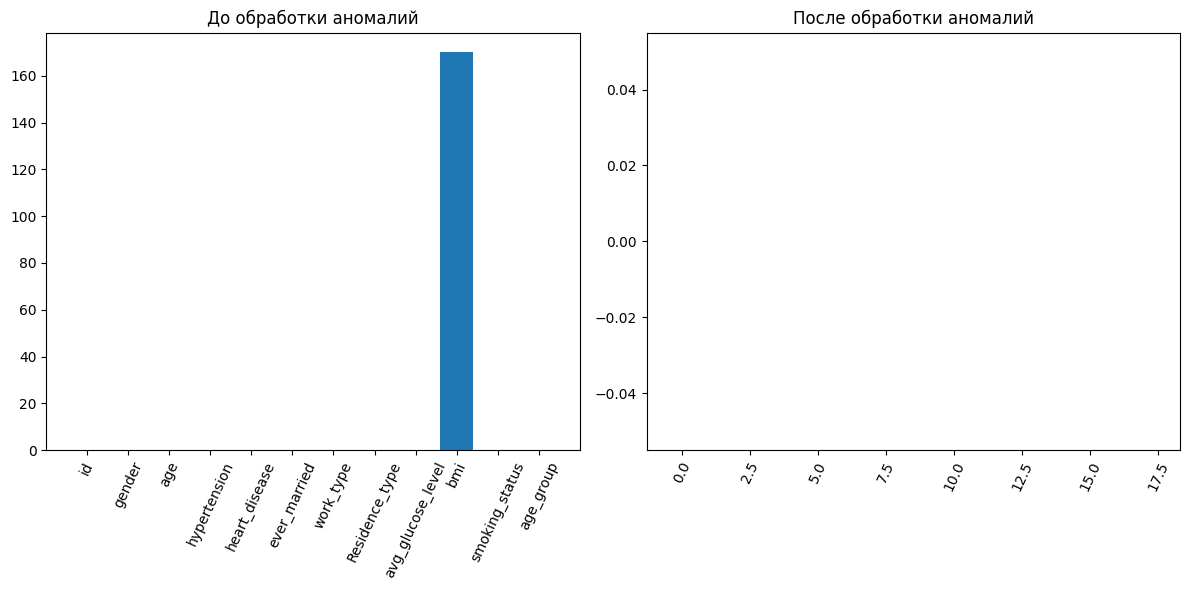

In [923]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
missing_values = X_train.isnull().sum()
plt.bar(missing_values.index, missing_values.values)
plt.xticks(rotation=65)
plt.title('До обработки аномалий')

plt.subplot(1, 2, 2)
missing_values = X_train_transform.isnull().sum()
plt.bar(missing_values.index, missing_values.values)
plt.xticks(rotation=65)
plt.title('После обработки аномалий')

plt.tight_layout()
plt.show()


In [924]:
#Решим вопрос с дисбалансом классов в таргете. Применим SMOTE 

smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_transform, y_train)


unique, counts = np.unique(y_smote_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)


{0: 3889, 1: 3889}


In [925]:
X_smote_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.205661,0.0,0.0,-0.822340,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.254901,0.0,0.0,0.363879,0.0,1.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.046590,0.0,0.0,0.099305,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.028623,0.0,0.0,-0.907325,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.299160,0.0,0.0,-0.528692,0.0,1.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7773,1.191050,0.0,0.0,-0.059899,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7774,0.742841,0.0,0.0,2.358075,0.0,0.215729,0.784271,0.215729,0.0,0.784271,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7775,0.336499,0.0,0.0,-0.097562,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7776,0.722217,0.0,0.0,0.157043,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [926]:
#Обучим несколько моделей
svm_model = SVC(random_state=42)
cboost_model = CatBoostClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42)
rfc_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
gbc_model = GradientBoostingClassifier(random_state=42)
models = [svm_model, rfc_model, xgb_model, gbc_model, cboost_model, lgbm_model, logreg_model]

for clf in models:
    clf.fit(X_smote_train, y_smote_train)
    add_model_results(clf, X_test_transform, y_test, f'{clf}')

Learning rate set to 0.024736
0:	learn: 0.6746866	total: 8.21ms	remaining: 8.21s
1:	learn: 0.6590663	total: 13.2ms	remaining: 6.59s
2:	learn: 0.6451879	total: 19.9ms	remaining: 6.6s
3:	learn: 0.6279521	total: 24.9ms	remaining: 6.2s
4:	learn: 0.6131681	total: 29.4ms	remaining: 5.85s
5:	learn: 0.6032681	total: 34.7ms	remaining: 5.75s
6:	learn: 0.5915710	total: 39ms	remaining: 5.54s
7:	learn: 0.5818636	total: 44ms	remaining: 5.45s
8:	learn: 0.5723475	total: 49.2ms	remaining: 5.42s
9:	learn: 0.5637262	total: 53.3ms	remaining: 5.28s
10:	learn: 0.5548462	total: 57.4ms	remaining: 5.16s
11:	learn: 0.5465631	total: 61.5ms	remaining: 5.06s
12:	learn: 0.5392365	total: 66.4ms	remaining: 5.04s
13:	learn: 0.5326287	total: 70.7ms	remaining: 4.98s
14:	learn: 0.5257462	total: 74.5ms	remaining: 4.89s
15:	learn: 0.5182097	total: 78.4ms	remaining: 4.82s
16:	learn: 0.5120700	total: 83.1ms	remaining: 4.8s
17:	learn: 0.5073862	total: 87.3ms	remaining: 4.76s
18:	learn: 0.5022730	total: 91.3ms	remaining: 4.71s

Перед собой я ставлю следующую задачу:

Мне нужно выявить как можно больше случаев вероятности инсульта. Поэтому у меня будет следующие ключевые метрики

1. F1 Score (Чтобы видеть, насколько хорошо модель попадает)
2. Recall (Важен для первого класса)
3. Macro recall (Для определения среднего recall)



In [927]:
results_df.sort_values(by='F1 Score', ascending=False)


,Model,F1 Score,Recall,AUC,Accuracy
4,GradientBoostingClassifier(random_state=42),0.239130,0.66,0.730720,0.794521
7,LogisticRegression(random_state=42),0.234234,0.78,0.764486,0.750489
6,LGBMClassifier(random_state=42),0.222222,0.18,0.578683,0.938356
3,"XGBClassifier(base_score=None, booster=None, c...",0.220339,0.26,0.601708,0.909980
2,RandomForestClassifier(random_state=42),0.193548,0.30,0.603704,0.877691
5,<catboost.core.CatBoostClassifier object at 0x...,0.189474,0.18,0.571481,0.924658
1,SVC(random_state=42),0.180685,0.58,0.665514,0.742661
0,Base CatBoost,0.039216,0.02,0.510000,0.952055


In [928]:
print('Test:', classification_report(y_test, gbc_model.predict(X_test_transform)))


Test:               precision    recall  f1-score   support

           0       0.98      0.80      0.88       972
           1       0.15      0.66      0.24        50

    accuracy                           0.79      1022
   macro avg       0.56      0.73      0.56      1022
weighted avg       0.94      0.79      0.85      1022



    Логистическая регрессия и градиентный бустинг показали лучший результат. Несмотря на то, что логистическая регрессия имеет лучший результат на recall, проверим гипотезу, что потратив время и ресурсы на тюнинг градиентного бустинга - добьемся лучшего результата

In [929]:
param_space = {
    'n_estimators': Integer(100, 300),  
    'learning_rate': Real(0.01, 0.2, 'log-uniform'), 
    'max_depth': Integer(3, 5), 
    'subsample': Real(0.8, 1.0), 
    'min_samples_split': Integer(2, 5)  
}

# Настройка байесовской оптимизации с использованием кросс-валидации
bayes_gbc = BayesSearchCV(
    estimator=gbc_model, 
    search_spaces=param_space, 
    n_iter=32, 
    cv=3, 
    scoring='recall',  
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)

bayes_gbc.fit(X_smote_train, y_smote_train)

add_model_results(bayes_gbc, X_test_transform, y_test, 'Bayes_GBC')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [930]:
param_space = {
    'n_estimators': Integer(100, 300),  
    'learning_rate': Real(0.01, 0.2, 'log-uniform'), 
    'max_depth': Integer(3, 5),  
    'subsample': Real(0.8, 1.0)  
}

bayes_cboost = BayesSearchCV(
    estimator=cboost_model, 
    search_spaces=param_space, 
    n_iter=32, 
    cv=3, 
    scoring='recall',  
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)
CatBoostClassifier()

bayes_cboost.fit(X_smote_train, y_smote_train)

add_model_results(bayes_cboost, X_test_transform, y_test, 'Bayes_Cboost')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [931]:
param_space = {
    'n_estimators': Integer(100, 300),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'), 
    'max_depth': Integer(3, 5), 
    'subsample': Real(0.8, 1.0),  
    'min_samples_split': Integer(2, 5) 
}

bayes_xgb = BayesSearchCV(
    estimator=xgb_model, 
    search_spaces=param_space, 
    n_iter=32, 
    cv=3, 
    scoring='recall',  
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)

bayes_xgb.fit(X_smote_train, y_smote_train)

add_model_results(bayes_xgb, X_test_transform, y_test, 'Bayes_XGB')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [932]:
results_df.sort_values(by='F1 Score', ascending=False)

,Model,F1 Score,Recall,AUC,Accuracy
8,Bayes_GBC,0.242991,0.78,0.770658,0.780000
10,Bayes_XGB,0.240602,0.64,0.725350,0.640000
4,GradientBoostingClassifier(random_state=42),0.239130,0.66,0.730720,0.794521
9,Bayes_Cboost,0.239130,0.44,0.662387,0.440000
7,LogisticRegression(random_state=42),0.234234,0.78,0.764486,0.750489
6,LGBMClassifier(random_state=42),0.222222,0.18,0.578683,0.938356
3,"XGBClassifier(base_score=None, booster=None, c...",0.220339,0.26,0.601708,0.909980
2,RandomForestClassifier(random_state=42),0.193548,0.30,0.603704,0.877691
5,<catboost.core.CatBoostClassifier object at 0x...,0.189474,0.18,0.571481,0.924658
1,SVC(random_state=42),0.180685,0.58,0.665514,0.742661


In [933]:
feature_importances = gbc_model.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X_smote_train.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

#Топ 10 важных признаков
top_n = 10
top_features = feature_importance_df.head(top_n)
print("Топ-{} важных признаков:".format(top_n))
top_features


Топ-10 важных признаков:


,feature,importance
0,0,0.849329
3,3,0.042908
10,10,0.014965
7,7,0.014374
9,9,0.014257
17,17,0.012630
16,16,0.010266
15,15,0.009371
14,14,0.008138
6,6,0.005843


<Axes: >

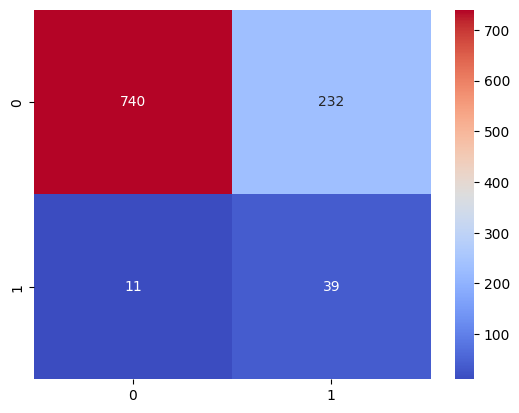

In [934]:
mod = metrics.confusion_matrix(y_test, bayes_gbc.predict(X_test_transform))
sns.heatmap(mod,annot=True,cmap='coolwarm', fmt='d')

In [935]:
print(round(recall_score(y_test, bayes_gbc.predict(X_test_transform), average='macro'), 3))

0.771


In [784]:
print(classification_report(y_test, bayes_gbc.predict(X_test_transform)))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022



****
Выводы
****

1. В процессе улучшения качества модели CatBoost были выполнены следующие шаги:
     - Обработка аномалий путем замены их на медианное значение.
     - Применение кодирования категориальных признаков с использованием One-Hot Encoding (OHE).
     - Балансировка классов с помощью метода Synthetic Minority Over-sampling Technique (SMOTE).
     - Применение оптимизации Байеса к некоторым моделям для улучшения результатов.

2. Наиболее эффективным оказался градиентный бустинг из библиотеки scikit-learn, к которому была применена оптимизация Байеса.

3. Возраст играет ключевую роль в прогнозировании целевой переменной.

Гипотеза про градиентный бустинг подтвердилась. 

     Мы добились хорошего результата с macro recall - 0.77. Модель смогла определить 39/50 случаев.